# What is this?
in this part I gonna see how much my model doing well. 

we learn here how to normalize our data, add layer to our model.

check model characteristic measurments like "RecaLL"

And more important is that we finally see binary classification in action

In [1]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#  Import libs that we need /  be sure you read a bit about them


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# these are pandas configs
# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# nothing to attention. just config keras float data type
tf.keras.backend.set_floatx('float32')

In [8]:
# like last verions we just get our row data from csv/  you can download it from my repo

# get all data
data_frame = pd.read_csv("/content/drive/MyDrive/bitcoin_ticker.csv")
# get btc data
data_frame = data_frame.loc[(data_frame['rpt_key'] == 'btc_usd')]
# in next versions we dont delete this columns at all. we del these here just to be simple for now
del data_frame["datetime_id"]
del data_frame["date_id"]
del data_frame["created_at"]
del data_frame["updated_at"]
del data_frame["market"]
del data_frame["rpt_key"]
del data_frame["bid"]
del data_frame["ask"]
 # shuffle the data_frame before doing anything
data_frame = data_frame.reindex(np.random.permutation(data_frame.index))

#  a big BUUUUT : we are not gonna use scale factor  we just gonna use z-score you will see
# first let me build train and test dataset
# build train data frame and test data frame
train_last_index = int(len(data_frame) * 0.80)
train_df, test_df = data_frame.iloc[0:train_last_index], data_frame.iloc[train_last_index:len(data_frame) + 1] # i just add +1 to make sure wont get anny train data in test data
 # shuffle the train_df after doing sepration
train_df = train_df.reindex(np.random.permutation(train_df.index))
train_df.head()

,last,diff_24h,diff_per_24h,low,high,volume
553394,2659.5,2569.0,3.5,2520.0,2690.0,699.0
194974,2801.8,2795.6,0.2,2700.0,2862.0,2543.7
383673,2446.1,2492.0,-1.8,2315.0,2541.0,22662.8
555034,2659.6,2576.0,3.2,2561.0,2690.0,632.7
476703,2554.2,2475.6,3.2,2470.0,2595.0,11856.2


#SO What is the z-score that i call it "Big But" loudly 

z-score convert our mutiple ranged data. to a flat and goodboy data
so we can use it easily. more than you think.

# we call it normalization babe

In [9]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

as you can see we don't define threshold
This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in feature_layer) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model.
( i just copied this code cell and use its own definition to descripe the code job )

In [10]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []


resolution_in_Zs = 0.3  # 3/10 of a standard deviation.

# Create a bucket feature column for latitude.
diff24h_as_a_numeric_column = tf.feature_column.numeric_column("diff_24h")
diff24h_boundaries = list(np.arange(int(min(train_df_norm['diff_24h'])), 
                                     int(max(train_df_norm['diff_24h'])), 
                                     resolution_in_Zs))
diff24h = tf.feature_column.bucketized_column(diff24h_as_a_numeric_column, diff24h_boundaries)

# Create a bucket feature column for longitude.
volume_as_a_numeric_column = tf.feature_column.numeric_column("volume")
volume_boundaries = list(np.arange(int(min(train_df_norm['volume'])), 
                                      int(max(train_df_norm['volume'])), 
                                      resolution_in_Zs))
volume = tf.feature_column.bucketized_column(volume_as_a_numeric_column, 
                                                volume_boundaries)
volume_x_diff24h = tf.feature_column.crossed_column([volume, diff24h], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(volume_x_diff24h)
feature_columns.append(crossed_feature)


low = tf.feature_column.numeric_column("low")
feature_columns.append(low)

high = tf.feature_column.numeric_column("high")
feature_columns.append(high)

# add feature  columns as layers for our model
feature_layer = layers.DenseFeatures(feature_columns)

In [11]:
def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

>> and like last two train we define our function. but with a little difference.
check and find it !

In [12]:
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])
  return model           


def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


# Invoke the creating, training, and plotting functions


Epoch 1/15


101/101 [==============================] - 1s 3ms/step - loss: 0.2423 - mean_squared_error: 0.2423
Epoch 2/15
101/101 [==============================] - 0s 3ms/step - loss: 0.0656 - mean_squared_error: 0.0656
Epoch 3/15
101/101 [==============================] - 0s 3ms/step - loss: 0.0638 - mean_squared_error: 0.0638
Epoch 4/15
101/101 [==============================] - 0s 3ms/step - loss: 0.0637 - mean_squared_error: 0.0637
Epoch 5/15
101/101 [==============================] - 0s 3ms/step - loss: 0.0637 - mean_squared_error: 0.0637
Epoch 6/15
101/101 [==============================] - 0s 3ms/step - loss: 0.0637 - mean_squared_error: 0.0637
Epoch 7/15
101/101 [==============================] - 0s 3ms/step - loss: 0.0637 - mean_squared_error: 0.0637
Epoch 8/15
101/101 [==============================] - 0s 3ms/step - loss: 0.0637 - mean_squared_error: 0.0637
Epoch 9/15
101/101 [==============================] - 0s 3ms/step - loss: 0.0637 - mean_squared_error: 0.0637
Epoch 10/15
101/101 [

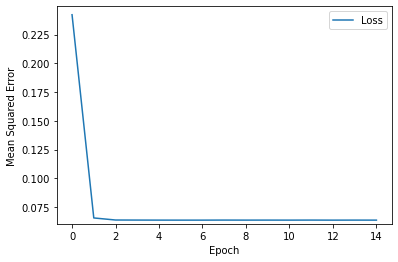


 Evaluate the linear regression model against the test set:
26/26 [==============================] - 0s 3ms/step - loss: 0.1111 - mean_squared_error: 0.1111


[0.11111327260732651, 0.11111327260732651]

In [14]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "last"

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)